In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from scipy import ndimage, misc
from skimage.transform import resize, rescale
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
%matplotlib inline

In [ ]:
print(tf.__version__)

2.1.0


**Encoder: CONV(64)-CONV(64)-POOL-CONV(128)-CONV(128)-POOL-CONV(256)**

In [ ]:
input_img= Input(shape=(256,256,3))
l1 = Conv2D(filters=64, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(filters=64, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(pool_size=(2, 2), padding="same")(l2)
l4 = Conv2D(filters=128, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(filters=128, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(pool_size=(2, 2), padding="same")(l5)
l7 = Conv2D(filters=256, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l6)
encoder= Model(input_img, l7)

**Decoder: CONV(128)-CONV(128)-UpSample-CONV(64)-CONV(64)-UpSample-CONV(3)**

In [ ]:
l8 = UpSampling2D(size=(2, 2))(l7)
l9 = Conv2D(filters=128, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l8)
l10= Conv2D(filters=128, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l9)
l11= add([l5,l10])
l12= UpSampling2D(size=(2, 2))(l11)
l13= Conv2D(filters=64, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l12)
l14= Conv2D(filters=64, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l13)
l15= add([l2,l14])
l16= Conv2D(filters=3, kernel_size=(3,3), padding="same",activation='relu',activity_regularizer=regularizers.l1(10e-10))(l15)

**Connect the Encoder & Decoder part to get the AutoEncoder**

In [ ]:
autoencoder= Model(input_img, l16)
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [ ]:
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

**Create Dataset and Specify Training Routine**

In [ ]:
def train_batches(just_load_dataset=False):

    batches = 256 

    batch = 0 
    batch_nb = 0 
    max_batches = -1 
    
    ep = 4 

    images = []
    x_train_n = []
    x_train_down = []
    
    x_train_n2 = [] 
    x_train_down2 = []
    
    for root, dirnames, filenames in os.walk("/home/rhyme/Desktop/Project/data/cars_train"):
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: 
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath)
                if len(image.shape) > 2:
                        
                    image_resized = resize(image, (256, 256))
                    x_train_n.append(image_resized)
                    x_train_down.append(rescale(rescale(image_resized, 0.5), 2.0))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1

                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)
                        
                        if just_load_dataset:
                            return x_train_n2, x_train_down2
                        
                        print('Training batch', batch_nb, '(', batches, ')')

                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)
                    
                        x_train_n = []
                        x_train_down = []
                    
                        batch = 0

    return x_train_n2, x_train_down2

In [ ]:
x_train_n, x_train_down= train_batches(just_load_dataset=True)

/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/rhyme/.local/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


**Import pre-trained weights**

In [ ]:
autoencoder.load_weights('/home/rhyme/Desktop/Project/data/sr.img_net.mse.final_model5.no_patch.weights.best.hdf5')

In [ ]:
encoder.load_weights('/home/rhyme/Desktop/Project/data/encoder_weights.hdf5')

In [ ]:
encoded_imgs= encoder.predict(x_train_down)
encoded_imgs.shape

(256, 64, 64, 256)

In [ ]:
sup_res_imgs= np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

In [ ]:
img_index= 2

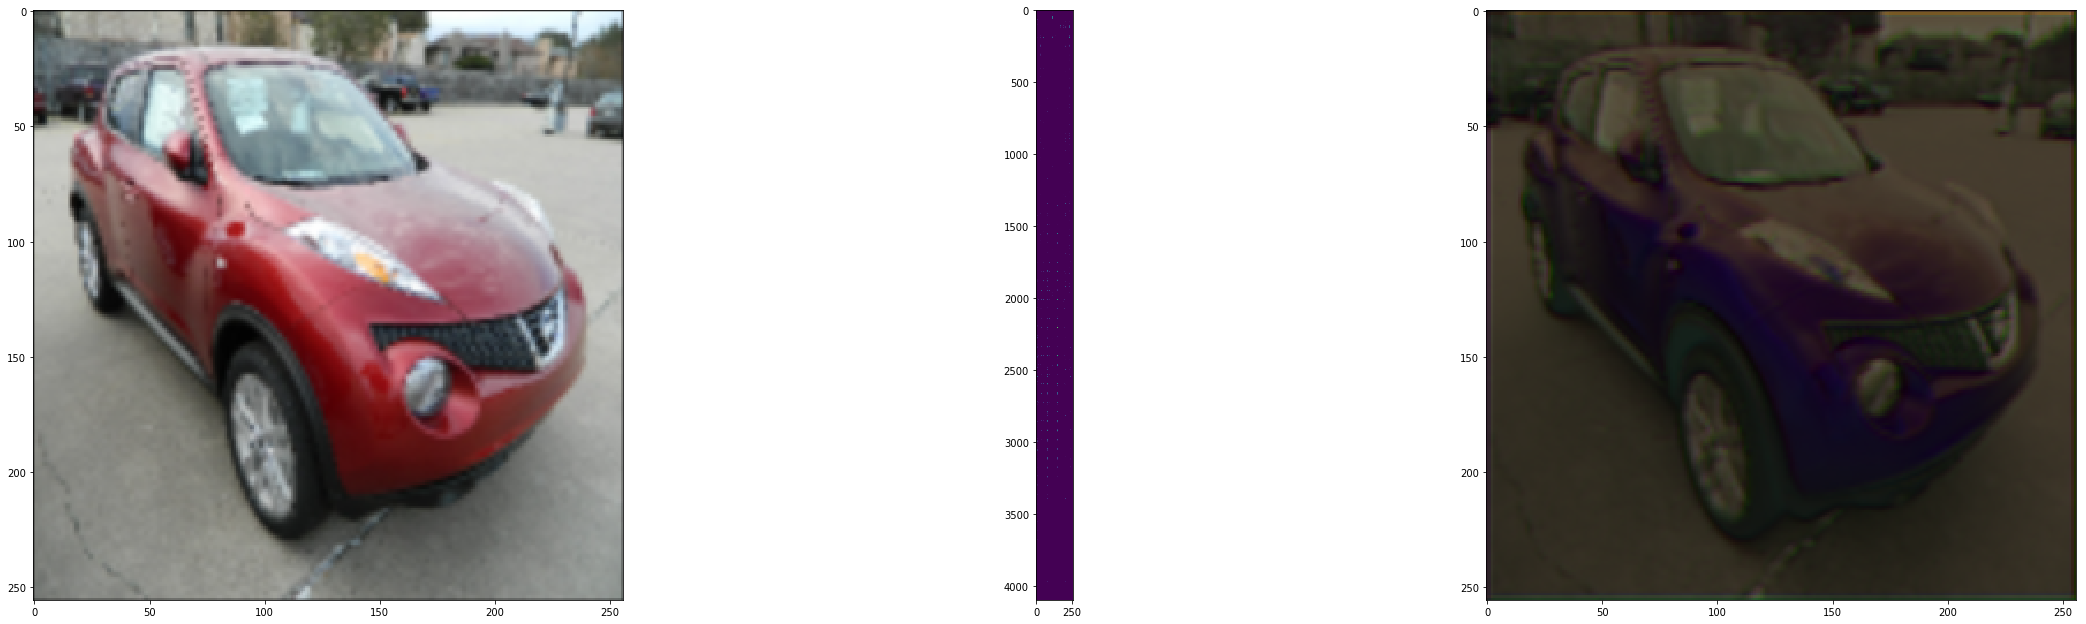

In [ ]:
plt.figure(figsize=(128,128))
i = 1
ax= plt.subplot(10, 10, i)
plt.imshow(x_train_down[img_index])
i+= 1
ax= plt.subplot(10, 10, i)
plt.imshow(encoded_imgs[img_index].reshape(64*64, 256))
i+= 1
ax= plt.subplot(10, 10, i)
plt.imshow(sup_res_imgs[img_index])